In [4]:
# import numpy as np
# import pygame
# import time
# from Octree import Octree, AABB

# class Cube:
#     def __init__(self, position, size=1):
#         self.position = np.array(position, dtype=float)
#         self.size = size
#         self.velocity = np.random.randn(2) * 2  # 随机初速度
#         self.color = (255, 255, 255)  # 默认白色
        
#     def update(self, dt):
#         # 更新位置
#         self.position += self.velocity * dt
        
#         # 碰到边界反弹
#         for i in range(2):
#             if self.position[i] <= 0 or self.position[i] >= 100 - self.size:
#                 self.velocity[i] *= -1
#                 self.position[i] = np.clip(self.position[i], 0, 100 - self.size)
                
#     def get_aabb(self):
#         return AABB(self.position, self.position + self.size)

# class CollisionSystem:
#     def __init__(self, num_cubes=2000):
#         self.cubes = []
#         self.intersects_check_count = 0
        
#         # 创建随机立方体
#         for _ in range(num_cubes):
#             position = np.random.uniform(0, 99, 2)
#             self.cubes.append(Cube(position))
            
#     def update(self, dt):
#         # 更新所有立方体位置
#         for cube in self.cubes:
#             cube.update(dt)
            
#         # 重置碰撞状态
#         for cube in self.cubes:
#             cube.color = (255, 255, 255)
            
#         # 重建八叉树
#         rebuild_start = time.time()
#         bounds = AABB(np.array([0, 0]), np.array([100, 100]))
#         octree = Octree(bounds)
        
#         # 插入所有立方体
#         for i, cube in enumerate(self.cubes):
#             octree.insert((i, cube), cube.get_aabb())
#         rebuild_time = time.time() - rebuild_start
        
#         # 碰撞检测
#         self.intersects_check_count = 0
#         check_start = time.time()
#         collisions = set()
        
#         def check_collision(aabb1, aabb2):
#             self.intersects_check_count += 1
#             return aabb1.intersects(aabb2)
        
#         # 遍历所有节点检查碰撞
#         def check_node(node):
#             # 检查当前节点中物体之间的碰撞
#             for i, (idx1, cube1) in enumerate(node.objects):
#                 for idx2, cube2 in node.objects[i+1:]:
#                     if check_collision(cube1.get_aabb(), cube2.get_aabb()):
#                         collisions.add(tuple(sorted((idx1, idx2))))
                        
#             # 递归检查子节点
#             if node.children:
#                 for child in node.children:
#                     check_node(child)
                    
#         check_node(octree.root)
#         check_time = time.time() - check_start
        
#         # 标记发生碰撞的立方体为红色
#         for idx1, idx2 in collisions:
#             self.cubes[idx1].color = (255, 0, 0)
#             self.cubes[idx2].color = (255, 0, 0)
            
#         return rebuild_time, check_time

# class Visualization:
#     def __init__(self):
#         pygame.init()
#         self.screen = pygame.display.set_mode((800, 800))
#         self.clock = pygame.time.Clock()
#         self.system = CollisionSystem()
        
#     def run(self):
#         running = True
#         frame_count = 0
#         start_time = time.time()
        
#         while running:
#             for event in pygame.event.get():
#                 if event.type == pygame.QUIT:
#                     running = False
                    
#             # 更新系统
#             dt = 0.016  # 固定时间步长
#             rebuild_time, check_time = self.system.update(dt)
            
#             # 渲染
#             self.screen.fill((0, 0, 0))
#             scale = 8  # 缩放因子
            
#             for cube in self.system.cubes:
#                 pos = cube.position * scale
#                 size = cube.size * scale
#                 pygame.draw.rect(self.screen, cube.color, 
#                                (pos[0], pos[1], size, size))
                
#             pygame.display.flip()
            
#             # 计算和显示性能指标
#             frame_count += 1
#             if frame_count % 60 == 0:
#                 fps = frame_count / (time.time() - start_time)
#                 print(f"FPS: {fps:.1f}")
#                 print(f"Rebuild time: {rebuild_time*1000:.2f}ms")
#                 print(f"Check time: {check_time*1000:.2f}ms")
#                 print(f"Intersects check count: {self.system.intersects_check_count}")
#                 print("-" * 40)
                
#             self.clock.tick(60)
            
#         pygame.quit()

# if __name__ == "__main__":
#     vis = Visualization()
#     vis.run()

In [5]:
import numpy as np
import pygame
import time

class AABB:
    """轴对齐包围盒"""
    def __init__(self, min_point, max_point):
        self.min_point = np.array(min_point)
        self.max_point = np.array(max_point)
    
    def intersects(self, other):
        """检查是否与另一个AABB相交"""
        return (np.all(self.min_point <= other.max_point) and 
                np.all(other.min_point <= self.max_point))

class OctreeNode:
    """八叉树节点"""
    def __init__(self, bounds, max_objects=4, max_depth=8):
        self.bounds = bounds  # 节点的AABB边界
        self.objects = []     # 存储在该节点的物体
        self.children = []    # 子节点
        self.max_objects = max_objects  # 节点可容纳的最大物体数
        self.max_depth = max_depth      # 最大深度
        self.depth = 0                  # 当前深度

class Octree:
    """八叉树"""
    def __init__(self, bounds, max_objects=4, max_depth=8):
        self.root = OctreeNode(bounds, max_objects, max_depth)
    
    def insert(self, obj, aabb):
        """插入物体及其AABB"""
        self._insert_recursive(self.root, obj, aabb)
    
    def _insert_recursive(self, node, obj, aabb):
        """递归插入物体"""
        # 如果物体不在节点范围内，返回False
        if not node.bounds.intersects(aabb):
            return False
            
        # 如果没有子节点且未达到对象数量限制，直接插入
        if not node.children and len(node.objects) < node.max_objects:
            node.objects.append((obj, aabb))
            return True
            
        # 如果需要细分且没有子节点
        if not node.children:
            self._subdivide(node)
            
            # 重新分配当前节点中的物体
            old_objects = node.objects
            node.objects = []
            
            for old_obj, old_aabb in old_objects:
                for child in node.children:
                    if self._insert_recursive(child, old_obj, old_aabb):
                        break
        
        # 尝试将物体插入到子节点
        inserted = False
        for child in node.children:
            if self._insert_recursive(child, obj, aabb):
                inserted = True
                break
                
        # 如果无法插入到任何子节点，存储在当前节点
        if not inserted:
            node.objects.append((obj, aabb))
            
        return True

    def _subdivide(self, node):
        """将节点分割为4个子节点（因为是2D场景，所以用四叉树而不是八叉树）"""
        if node.depth >= node.max_depth:
            return
        
        center = (node.bounds.min_point + node.bounds.max_point) / 2
        
        # 创建4个子节点
        for i in range(4):
            min_point = np.copy(node.bounds.min_point)
            max_point = np.copy(node.bounds.max_point)
            
            # 根据i的二进制位确定子节点位置
            if i & 1: min_point[0] = center[0]
            else: max_point[0] = center[0]
            if i & 2: min_point[1] = center[1]
            else: max_point[1] = center[1]
            
            child = OctreeNode(AABB(min_point, max_point), 
                             node.max_objects, node.max_depth)
            child.depth = node.depth + 1
            node.children.append(child)

# ...原有的 Cube, CollisionSystem 和 Visualization 类保持不变...

In [1]:
class Visualization:
    # ...existing code...
    
    def update(self, dt):
        # 更新所有立方体位置
        for cube in self.cubes:
            cube.update(dt)
        
        # 重置碰撞状态
        for cube in self.cubes:
            cube.color = (255, 255, 255)
        
        # 构建八叉树
        rebuild_start = time.time()
        bounds = AABB(np.array([0, 0]), np.array([100, 100]))
        octree = Octree(bounds)
        
        for i, cube in enumerate(self.cubes):
            octree.insert((i, cube), cube.get_aabb())
        
        self.rebuild_time = time.time() - rebuild_start
        
        # 碰撞检测
        check_start = time.time()
        self.intersects_check_count = 0
        collisions = set()
        
        def check_node_collisions(node):
            # 检查当前节点中物体之间的碰撞
            for i, (idx1, cube1) in enumerate(node.objects):
                for j, (idx2, cube2) in enumerate(node.objects[i+1:], i+1):
                    self.intersects_check_count += 1
                    # 直接使用存储在节点中的AABB进行碰撞检测
                    if node.objects[i][1].intersects(node.objects[j][1]):
                        collisions.add(tuple(sorted((idx1, idx2))))
            
            # 检查子节点
            if node.children:
                for child in node.children:
                    check_node_collisions(child)
        
        check_node_collisions(octree.root)
        self.check_time = time.time() - check_start
        
        # 标记碰撞的立方体
        for idx1, idx2 in collisions:
            self.cubes[idx1].color = (255, 0, 0)
            self.cubes[idx2].color = (255, 0, 0)

In [2]:
class Quadtree:
    def __init__(self, bounds, max_objects=10, max_depth=5):
        self.bounds = bounds
        self.max_objects = max_objects
        self.max_depth = max_depth
        self.objects = []
        self.children = []
        self.depth = 0
    
    def split(self):
        if self.children:
            return
            
        center_x = (self.bounds.min[0] + self.bounds.max[0]) / 2
        center_y = (self.bounds.min[1] + self.bounds.max[1]) / 2
        
        # 创建四个子节点
        nw = AABB(np.array([self.bounds.min[0], center_y]), 
                  np.array([center_x, self.bounds.max[1]]))
        ne = AABB(np.array([center_x, center_y]), 
                  np.array([self.bounds.max[0], self.bounds.max[1]]))
        sw = AABB(np.array([self.bounds.min[0], self.bounds.min[1]]), 
                  np.array([center_x, center_y]))
        se = AABB(np.array([center_x, self.bounds.min[1]]), 
                  np.array([self.bounds.max[0], center_y]))
                  
        self.children = [Quadtree(quad, self.max_objects, self.max_depth) 
                        for quad in [nw, ne, sw, se]]
        
        # 重新分配对象到子节点
        for obj in self.objects:
            self._insert_to_children(obj)
        self.objects = []

    def _insert_to_children(self, obj):
        idx, cube = obj
        for child in self.children:
            if child.bounds.contains(cube.get_aabb()):
                child.insert(obj)
                return

In [3]:
def update(self, dt):
    # 更新所有立方体位置和AABB
    for cube in self.cubes:
        cube.update(dt)
        cube.color = (255, 255, 255)
    
    # 构建四叉树
    rebuild_start = time.time()
    bounds = AABB(np.array([0, 0]), np.array([100, 100]))
    quadtree = Quadtree(bounds)
    
    for i, cube in enumerate(self.cubes):
        quadtree.insert((i, cube), cube.get_aabb())
    
    self.rebuild_time = time.time() - rebuild_start
    
    # 碰撞检测
    check_start = time.time()
    self.intersects_check_count = 0
    collisions = set()
    
    def check_collisions(node):
        # 检查当前节点中的碰撞
        for i, (idx1, cube1) in enumerate(node.objects):
            for j, (idx2, cube2) in enumerate(node.objects[i+1:], i+1):
                self.intersects_check_count += 1
                if cube1.get_aabb().intersects(cube2.get_aabb()):
                    collisions.add(tuple(sorted((idx1, idx2))))
        
        # 递归检查子节点
        for child in node.children:
            check_collisions(child)
    
    check_collisions(quadtree.root)
    self.check_time = time.time() - check_start
    
    # 标记碰撞的立方体
    for idx1, idx2 in collisions:
        self.cubes[idx1].color = (255, 0, 0)
        self.cubes[idx2].color = (255, 0, 0)

FPS: 14.0 | Rebuild Time: 1.0ms | Check Time: 47.6ms | Checks: 317328
FPS: 20.4 | Rebuild Time: 0.0ms | Check Time: 46.0ms | Checks: 315180


C:\Users\asus\AppData\Local\Temp\ipykernel_56452\4122623255.py:120: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=1, blit=True)


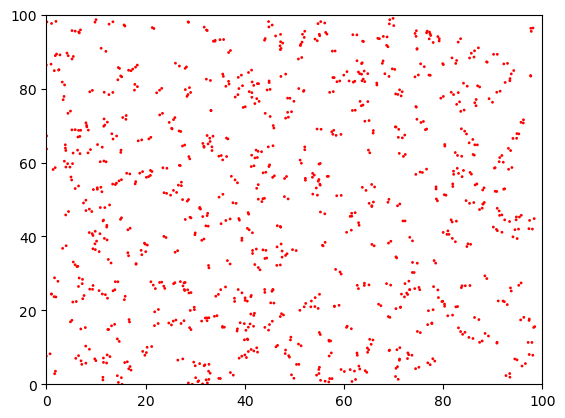

In [23]:
import time
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 参数配置
SPACE_SIZE = 100
NUM_BLOCKS = 2000
BLOCK_SIZE = 1
GRID_SIZE = 10  # 网格划分大小，影响性能
VELOCITY_RANGE = (-2, 2)  # 速度范围

class Block:
    def __init__(self):
        self.x = random.uniform(0, SPACE_SIZE - BLOCK_SIZE)
        self.y = random.uniform(0, SPACE_SIZE - BLOCK_SIZE)
        self.vx = random.uniform(*VELOCITY_RANGE)
        self.vy = random.uniform(*VELOCITY_RANGE)
        self.color = 'white'

    def move(self):
        # 移动并处理边界反弹
        self.x += self.vx
        self.y += self.vy
        if self.x < 0 or self.x + BLOCK_SIZE > SPACE_SIZE:
            self.vx *= -1
            self.x = max(0, min(SPACE_SIZE - BLOCK_SIZE, self.x))
        if self.y < 0 or self.y + BLOCK_SIZE > SPACE_SIZE:
            self.vy *= -1
            self.y = max(0, min(SPACE_SIZE - BLOCK_SIZE, self.y))

class CollisionDetector:
    def __init__(self):
        self.grid = {}
        self.rebuild_time = 0
        self.check_time = 0
        self.intersects_check_count = 0

    def _get_grid_key(self, x, y):
        # 计算方块所属的网格坐标
        return (int(x // GRID_SIZE), int(y // GRID_SIZE))

    def rebuild_grid(self, blocks):
        # 重建网格数据结构
        start = time.time()
        self.grid.clear()
        for block in blocks:
            key = self._get_grid_key(block.x, block.y)
            if key not in self.grid:
                self.grid[key] = []
            self.grid[key].append(block)
        self.rebuild_time = time.time() - start

    def check_collisions(self):
        # 检测碰撞并标记颜色
        start = time.time()
        self.intersects_check_count = 0
        for (gx, gy), blocks in self.grid.items():
            # 检测当前网格及其相邻8个网格
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    neighbor_key = (gx + dx, gy + dy)
                    if neighbor_key not in self.grid:
                        continue
                    for block1 in blocks:
                        for block2 in self.grid[neighbor_key]:
                            if block1 == block2:
                                continue
                            self.intersects_check_count += 1
                            if self._aabb_collision(block1, block2):
                                block1.color = 'red'
                                block2.color = 'red'
        self.check_time = time.time() - start

    def _aabb_collision(self, a, b):
        # AABB碰撞检测
        return (a.x < b.x + BLOCK_SIZE and
                a.x + BLOCK_SIZE > b.x and
                a.y < b.y + BLOCK_SIZE and
                a.y + BLOCK_SIZE > b.y)

# 初始化
blocks = [Block() for _ in range(NUM_BLOCKS)]
detector = CollisionDetector()
fig, ax = plt.subplots()
scatter = ax.scatter([b.x for b in blocks], [b.y for b in blocks], c='white', s=1)

# 性能统计
fps = 0
last_time = time.time()

def update(frame):
    global fps, last_time
    # 移动方块
    for block in blocks:
        block.move()
        block.color = 'white'  # 重置颜色
    
    # 碰撞检测
    detector.rebuild_grid(blocks)
    detector.check_collisions()
    
    # 更新绘图数据
    scatter.set_offsets([(b.x, b.y) for b in blocks])
    scatter.set_color([b.color for b in blocks])
    
    # 计算帧率
    current_time = time.time()
    fps = 1 / (current_time - last_time)
    last_time = current_time
    
    # 打印性能数据
    print(f"FPS: {fps:.1f} | "
          f"Rebuild Time: {detector.rebuild_time*1000:.1f}ms | "
          f"Check Time: {detector.check_time*1000:.1f}ms | "
          f"Checks: {detector.intersects_check_count}")
    return scatter,

# 运行动画
ani = FuncAnimation(fig, update, interval=1, blit=True)
plt.xlim(0, SPACE_SIZE)
plt.ylim(0, SPACE_SIZE)
plt.show()

In [26]:
class CollisionDetector:
    def __init__(self):
        self.check_time = 0
        self.intersects_check_count = 0

    def check_collisions(self, blocks):
        # 暴力检测所有方块对之间的碰撞
        start = time.time()
        self.intersects_check_count = 0
        
        for i in range(len(blocks)):
            for j in range(i + 1, len(blocks)):
                self.intersects_check_count += 1
                if self._aabb_collision(blocks[i], blocks[j]):
                    blocks[i].color = 'red'
                    blocks[j].color = 'red'
        
        self.check_time = time.time() - start

    def _aabb_collision(self, a, b):
        # AABB碰撞检测
        return (a.x < b.x + BLOCK_SIZE and
                a.x + BLOCK_SIZE > b.x and
                a.y < b.y + BLOCK_SIZE and
                a.y + BLOCK_SIZE > b.y)

C:\Users\asus\AppData\Local\Temp\ipykernel_56452\1522744413.py:69: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=1, blit=True)
C:\Users\asus\AppData\Local\Temp\ipykernel_56452\1522744413.py:69: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from current font.
  ani = FuncAnimation(fig, update, interval=1, blit=True)
C:\Users\asus\AppData\Local\Temp\ipykernel_56452\1522744413.py:69: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  ani = FuncAnimation(fig, update, interval=1, blit=True)
C:\Users\asus\AppData\Local\Temp\ipykernel_56452\1522744413.py:69: UserWarning: Glyph 30896 (\N{CJK UNIFIED IDEOGRAPH-78B0}) missing from current font.
  ani 

TypeError: CollisionDetector.check_collisions() takes 1 positional argument but 2 were given

c:\Users\asus\.conda\envs\pytorch_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asus\.conda\envs\pytorch_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asus\.conda\envs\pytorch_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30896 (\N{CJK UNIFIED IDEOGRAPH-78B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asus\.conda\envs\pytorch_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25758 (\N{CJK UNIFIED IDEOGRAPH-649E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\asus\.conda\envs\pytorch_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-6

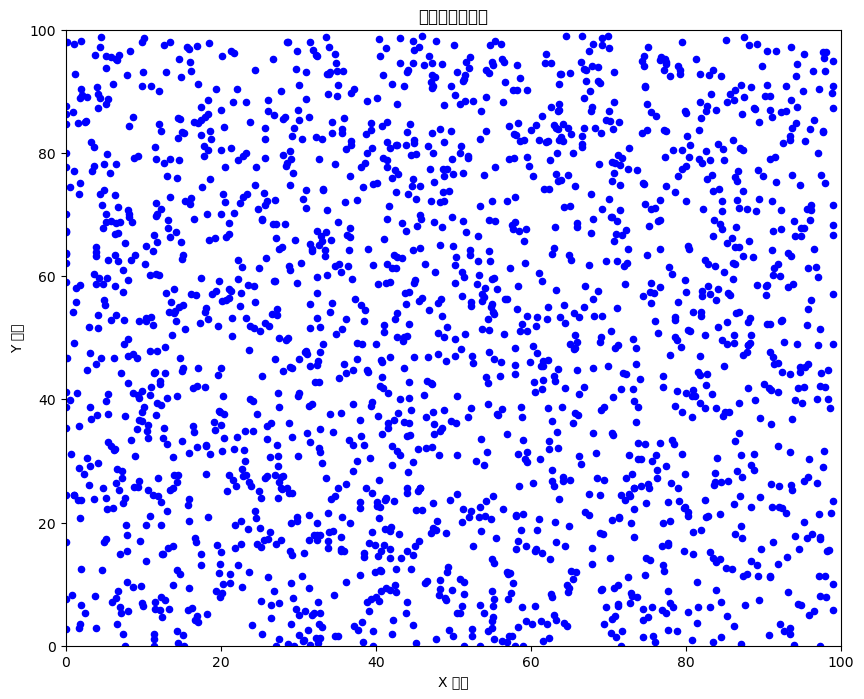

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class CollisionDetector:
    def __init__(self):
        self.check_time = 0
        self.intersects_check_count = 0
        self.collision_count = 0  # 添加碰撞计数器

    def check_collisions(self, blocks):
        start = time.time()
        self.intersects_check_count = 0
        self.collision_count = 0  # 重置碰撞计数
        
        for i in range(len(blocks)):
            blocks[i].color = 'blue'  # 默认颜色设为蓝色
            for j in range(i + 1, len(blocks)):
                self.intersects_check_count += 1
                if self._aabb_collision(blocks[i], blocks[j]):
                    blocks[i].color = 'red'
                    blocks[j].color = 'red'
                    self.collision_count += 1  # 统计碰撞次数
        
        self.check_time = time.time() - start

# 修改update函数
def update(frame):
    global fps, last_time
    # 移动方块
    for block in blocks:
        block.move()
    
    # 碰撞检测
    detector.check_collisions(blocks)
    
    # 更新绘图数据
    scatter.set_offsets([(b.x, b.y) for b in blocks])
    scatter.set_color([b.color for b in blocks])
    
    # 更新统计信息文本
    current_time = time.time()
    fps = 1 / (current_time - last_time)
    last_time = current_time
    
    stats_text.set_text(f'FPS: {fps:.1f}\n'
                       f'检查次数: {detector.intersects_check_count}\n'
                       f'碰撞数量: {detector.collision_count}\n'
                       f'检测时间: {detector.check_time*1000:.1f}ms')
    
    return scatter, stats_text

# 初始化绘图
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter([b.x for b in blocks], [b.y for b in blocks], c='blue', s=20)

# 添加统计信息文本
stats_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, 
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 设置图表属性
ax.set_xlim(0, SPACE_SIZE)
ax.set_ylim(0, SPACE_SIZE)
ax.set_title('碰撞检测可视化')
ax.set_xlabel('X 坐标')
ax.set_ylabel('Y 坐标')

# 运行动画
ani = FuncAnimation(fig, update, interval=1, blit=True)
plt.show()